<img align="top" width="125" height="125" src="https://pbs.twimg.com/profile_images/1286339140502654977/FmPAcETU_400x400.jpg" alt="banner">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/ps/api-training/inference/basic_inference.ipynb)

# General Information

This notebook is to be used to retrieve basic inference from the Clarifai Platform. In this tutorial, you will learn how to get basic inferece of images with URLS and local paths.

## How to Run
You can run each code cell independently by using `SHIFT + ENTER`. You can also run the whole notebook (all cells) using `RUN ALL`.

## Expected inputs

- The app ID **(required)**
- The user ID **(required)**
- An PAT key token **(required)**
- A model ID **(required)**
- A model version ID **(optional)**

## Limitations

- Not meant for running inference for videos
- Not meant for running inference for object detection


# Table of contents

- [Python requirements](#Python-requirements)
- [Imports](#Imports)
- [Setup Variables](#Setup-Variables)
- [Helper functions (ignore)](<#Helper-functions-(ignore)>)
- [Inference one image (using URL)](<#Inference-one-image-(using-URL)>)
- [Inference one image (using local file)](<#Inference-one-image-(using-local-file)>)
- [Inference multiple images (using URL)](<#Inference-multiple-images-(using-URL)>)
- [Inference multiple images (using local)](<#Inference-multiple-images-(using-local)>)


# Python requirements

Dependencies:

- clarifai_grpc
- pillow
- tqdm
- validators
- matplotlib
- pandas 
- scikit-learn


You can run the following cell to install all three required dependencies. They are required for this notebook.


In [3]:
!pip -q install clarifai-grpc==8.11.0
!pip -q install pillow==9.4.0
!pip -q install tqdm==4.64.1
!pip -q install validators==0.11.2
!pip -q install matplotlib==3.1.3
!pip -q install pandas==1.4.3
!pip -q install scikit-learn==1.1.2
!pip -q install plotly==5.9.0

Run the following code cell to restart your runtime environment. This is needed to make sure all the libraries are installed properly.

In [ ]:
import os
os.kill(os.getpid(), 9)

# Imports

In this section, we will be importing some of the required libraries.


In [5]:
# Standard imports
import re
import os
import sys
import glob
import time
from typing import Any, List, Tuple, Optional, Dict, Iterator, Iterable
from pathlib import Path
import requests
from io import BytesIO
import validators
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Imports
from PIL import Image
from tqdm.notebook import tqdm
from google.protobuf.struct_pb2 import Struct
from google.protobuf.json_format import MessageToJson, MessageToDict

# Clarifai imports
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2


# Setup Variables

Please fill up the following variables. They are needed to run the notebook.

## Authentication
Please fill the following section with your application PAT key (red), user id (blue) and app id (green). The following picture demonstrates where to find the PAT key (red) and the APP ID (green).

<img src="https://i.imgur.com/9ZeIieK.png" alt="drawing" width="800" height="750"/>

<img src="https://i.imgur.com/fx29FyC.png" alt="drawing" width="800" height="750"/>

<img src="https://i.imgur.com/w48dab8.png" alt="drawing" width="800" height="750"/>

## Global Variables

Global variables that will be reused throughout the notebook


In [14]:
##################################################################################
# In this section, we set the user authentication, app ID, and the workflow id
# that we will be using for predictions. Change these strings to run your own example.
##################################################################################

# Your user id in portal. You can find it under "profile" settings
USER_ID = "INPUT YOUR USER ID HERE"

# Your API key for your application. Make sure the API scopes have Model, Predict and Workflow enabled
PAT = "INPUT YOUR PERSONAL ACCESS TOKEN HERE"

# Your unique application ID. It should be written on the top left when first entering the application home page
APP_ID = "INPUT YOUR APP ID HERE"


# Change these to whatever model and image URL you want to use
MODEL_ID = "INPUT_HERE_YOUR_MODEL_ID"

# Add model version (optional)
MODEL_VERSION_ID = "INPUT_HERE_YOUR_MODEL_VERSION_ID"



The channel, stub and metadata will be used to call the Clarifai API


In [15]:
# Construct the communications channel and the object stub to call requests on.
channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)
metadata = (("authorization", "Key " + PAT),)

# The user data object that will be used for all requests when you are using the PAT authentication
# It is not needed if you are calling the API with the API key
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)


# Helper functions (ignore)

This section contains helper functions that simplify and organize the code. You do not have to modify these functions. 


In [16]:

########################################################################################
####### This function is used to run inference for a model on Clarifai's platform ######
########################################################################################

def get_images_predictions(MODEL_ID, MODEL_VERSION_ID, IMAGE_PATH):
    
    """Function that runs inference for multiple images from a Clarifai model.

    Args:
        MODEL_ID (str): Model ID for inference
        MODEL_VERSION_ID (str, optional): Model version, optional defaults to the latest model version
        IMAGE_PATH (List[str]): Local Path or URL of image for inference

    """
    
    predicted_concepts = []
    
    for image in IMAGE_PATH:
        
        image_inputs = []

        if str(image).startswith("http") and validators.url(image): 
              image_inputs.append(
                  resources_pb2.Input(
                      data=resources_pb2.Data(
                          image=resources_pb2.Image(url=image))
                  )
              ) 

        else:
            local_image = Path(image)
            with open(local_image, "rb") as f:
                file_bytes = f.read()
                image_inputs.append(
                    resources_pb2.Input(
                        data=resources_pb2.Data(image=resources_pb2.Image(base64=file_bytes))
                    )
                )

        post_model_outputs_response = stub.PostModelOutputs(
            service_pb2.PostModelOutputsRequest(
                user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
                model_id=MODEL_ID,
                version_id=MODEL_VERSION_ID,  # This is optional. Defaults to the latest model version
                inputs=image_inputs
            ),
            metadata=metadata
        )

        if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
            # print(post_model_outputs_response.status)
            raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)

        # Since we have one input, one output will exist here
        output = post_model_outputs_response.outputs[0]

        predicted_concepts.append(
            {"predicted concept": output.data.concepts[0].name, "value": output.data.concepts[0].value}
        )
        
    return predicted_concepts
        
    

def create_subplot(image_paths, concepts, num_rows=1, figsize=(10, 10)):
    
    num_image = len(image_paths)
    remove_last = False
    if num_image % 2 == 0:
        num_cols = int(num_image / num_rows)
    else:
        remove_last = True
        num_cols = int((num_image + 1) / num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.flatten()
    for image_path, concept, ax in zip(image_paths, concepts, axs):
        ax.set_axis_off()
        ax.text(
            0.5,
            0.08,
            f"{concept}",
            fontsize=12,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="green", alpha=0.60),
        )
        if os.path.exists(image_path):
            img = local_path_to_image(image_path)
        else:
            img = url_to_image(image_path)
        ax.imshow(img)
    if remove_last:
        fig.delaxes(axs[-1])  # The indexing is zero-based here

    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1)
    plt.show()
    
def url_to_image(url):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img

def local_path_to_image(image_path):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img

def check_stored_image(image_store):
    
    DATA_DIR = Path(image_store)
    file_types = ("*.jpg", "*.jpeg", "*.tiff", "*.png")  # Add more extensions if needed

    IMAGE_PATHS = []
    for file_type in file_types:
        IMAGE_PATHS.extend(glob.glob(str(DATA_DIR / file_type)))

    IMAGE_PATHS = [Path(image_path) for image_path in IMAGE_PATHS]
    print(f'You have {len(IMAGE_PATHS)} image(s) stored')
    return IMAGE_PATHS

def plot_confusion_matrix(concept_true, concept_pred, labels, title):

    z = confusion_matrix(concept_true, concept_pred, labels=labels)
    data = go.Heatmap(z=z, y=labels, x=labels, colorscale = 'blues')
    annotations = []
    for i, row in enumerate(z):
        for j, value in enumerate(row):
            annotations.append(
                {
                    "x": labels[i],
                    "y": labels[j],
                    "font": {"color": "grey"},
                    "text": str(value),
                    "xref": "x1",
                    "yref": "y1",
                    "showarrow": False
                }
            )
    layout = {
        "title": title,
        "xaxis": {"title": "True class"},
        "yaxis": {"title": "Predicted class"},
        "annotations": annotations
    }
    fig = go.Figure(data=data, layout=layout)
    return fig

def print_results(true_class, pred_class, class_labels, title):

    print('Classification Report'),
        
    print(
        classification_report(
            true_class, pred_class
        )),

    plot_confusion_matrix(
        labels = class_labels, 
        title = title, 
        concept_true = true_class, 
        concept_pred = pred_class
    ).show()

# Inference one image (using URL)

## Prepare

Let's prepare an image URL for inference, you can change this URL to any other image you'd like to run inference on.

In [17]:
IMAGE_URL = 'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_0.jpg'
labels = 'dog'

## View Image

Now that we have the URL loaded, let's view the image before running inference

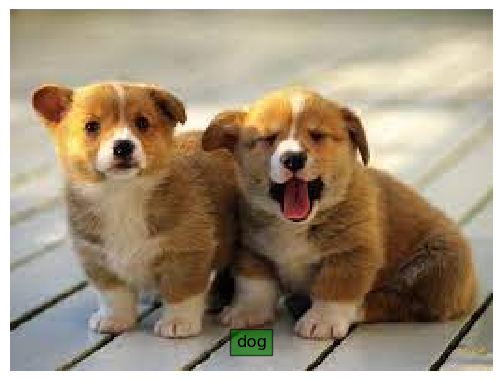

In [18]:
create_subplot(image_paths=[IMAGE_URL], concepts=[labels], num_rows=1, figsize=(10, 10))

## Single image inference (via URL)

Let's see if our model predicted our image correctly

In [19]:

post_model_outputs_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        model_id=MODEL_ID,
        version_id=MODEL_VERSION_ID,  # This is optional. Defaults to the latest model version
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    image=resources_pb2.Image(
                        url=IMAGE_URL
                    )
                )
            )
        ]
    ),
    metadata=metadata
)
if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_model_outputs_response.status)
    raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)

# Since we have one input, one output will exist here
output = post_model_outputs_response.outputs[0]
print(f'predicted concept: {output.data.concepts[0].name}, value: {output.data.concepts[0].value}')


predicted concept: dog, value: 0.9966592788696289


# Inference one image (using local file)

## Prepare

Let's prepare some locally stored images that we'd like to run inference on.

In [37]:
!mkdir -p ./data

!wget -q -O ./data/test_1_image.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_9.jpeg

Let's check to see if our image was saved to our local directory

In [38]:
single_image = check_stored_image(image_store="./data/")
str(single_image)

You have 1 image(s) stored


"[PosixPath('data/test_1_image.jpg')]"

In [39]:
IMAGE_LOCAL = Path("./data/test_1_image.jpg")
labels='dog'


## View Image

Now that we have our local image loaded, let's view the image before running inference

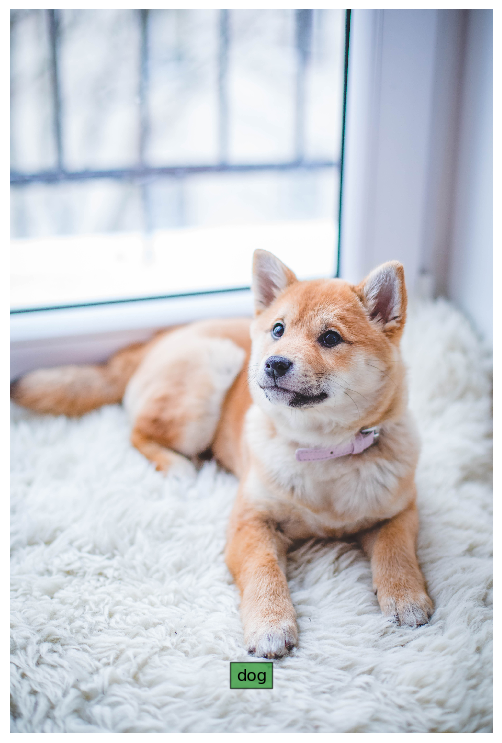

In [42]:
create_subplot(image_paths=[IMAGE_LOCAL], concepts=[labels], num_rows=1, figsize=(10, 10))

## Single image inference (via local)

In [43]:
# Note since out function takes a string for IMAGE_PATH 
# get_images_predictions(MODEL_ID, MODEL_VERSION_ID, IMAGE_PATH=str(IMAGE_PATH[0]))
with open(IMAGE_LOCAL, "rb") as f:
    file_bytes = f.read()
    
post_model_outputs_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        model_id=MODEL_ID,
        version_id=MODEL_VERSION_ID,  # This is optional. Defaults to the latest model version
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    image=resources_pb2.Image(
                        base64=file_bytes
                    )
                )
            )
        ]
    ),
    metadata=metadata
)
if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_model_outputs_response.status)
    raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)

print(f'predicted concept: {output.data.concepts[0].name}, value: {output.data.concepts[0].value}')

predicted concept: dog, value: 0.9966592788696289


# Inference multiple images (using URL)

## Prepare

Let's prepare a list of URLs for inference

In [44]:

image_urls = [
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_8.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_9.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_10.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_11.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_12_image.webp',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_13_image.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_14_image.jpeg',
    'https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_15.jpeg'
]

labels_url = ['cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog']

## View Images

Now that we have the URL set up, we can view the image

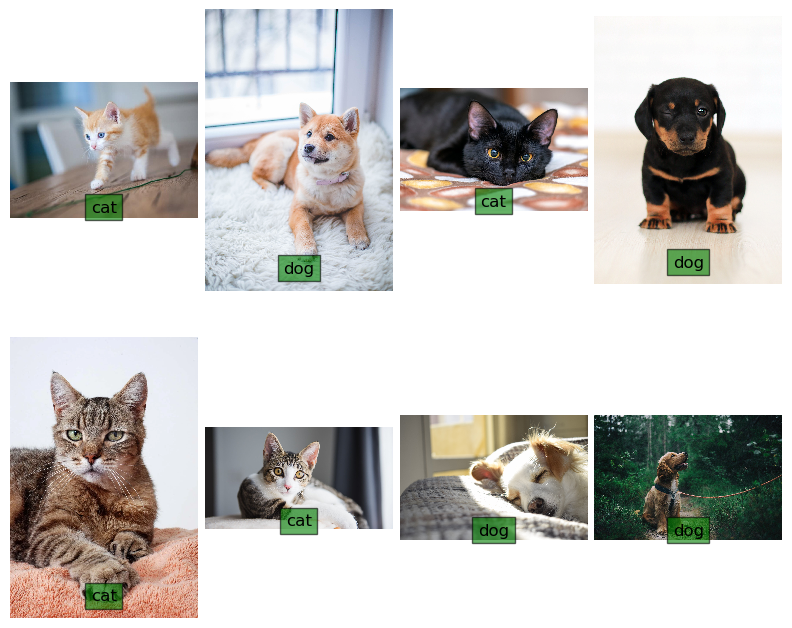

In [45]:
create_subplot(image_paths=image_urls, concepts=labels_url, num_rows=2, figsize=(8, 8))

## Run Inference multiple images

In [46]:
predictions_url = get_images_predictions(MODEL_ID, MODEL_VERSION_ID, IMAGE_PATH = image_urls)
predictions_url

[{'predicted concept': 'cat', 'value': 0.9986248016357422},
 {'predicted concept': 'dog', 'value': 0.9954115748405457},
 {'predicted concept': 'cat', 'value': 0.998708963394165},
 {'predicted concept': 'dog', 'value': 0.9982118606567383},
 {'predicted concept': 'cat', 'value': 0.9995459914207458},
 {'predicted concept': 'cat', 'value': 0.9950992465019226},
 {'predicted concept': 'dog', 'value': 0.9979293346405029},
 {'predicted concept': 'dog', 'value': 0.9950265288352966}]

In [47]:
mult_pred_url = pd.DataFrame(predictions_url)

## Basic evaluation report

Let's take a look at how well our model classified dogs and cats

Classification Report
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00         4
         dog       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



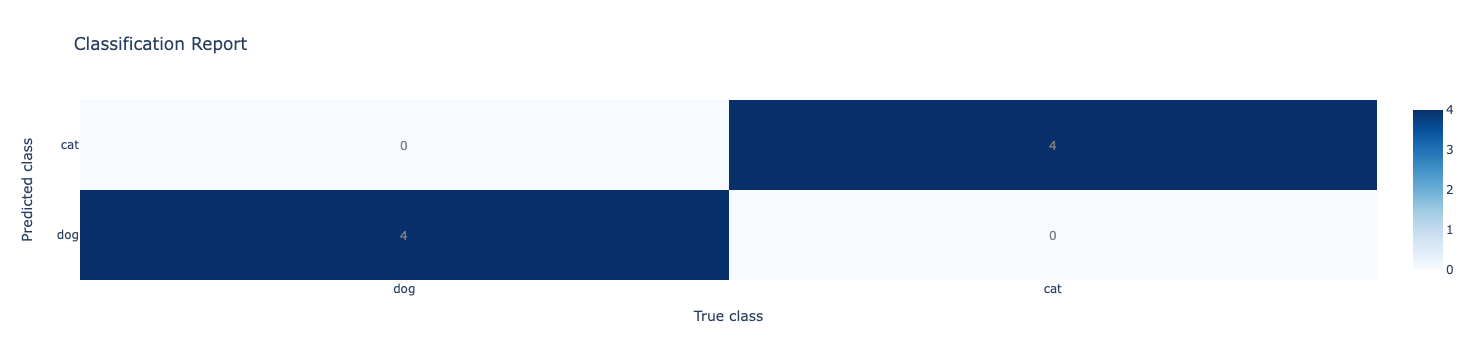

In [48]:
print_results(
    true_class=labels_url, 
    pred_class = mult_pred_url['predicted concept'], 
    class_labels=['dog', 'cat'], 
    title="Classification Report"
)

# Inference multiple images (using local)

## Prepare

Let's prepare our local images for inference

### Getting Image Paths

Here we will be getting all local paths to the downloaded images.

In [49]:
!mkdir -p ./data_mult

!wget -q -O ./data_mult/test_image_8.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_8.jpeg
!wget -q -O ./data_mult/test_image_9.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_9.jpeg
!wget -q -O ./data_mult/test_image_10.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_10.jpeg
!wget -q -O ./data_mult/test_image_11.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_11.jpeg
!wget -q -O ./data_mult/test_image_12.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_12_image.webp
!wget -q -O ./data_mult/test_image_13.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_13_image.jpeg
!wget -q -O ./data_mult/test_image_14.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_14_image.jpeg
!wget -q -O ./data_mult/test_image_15.jpg https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_15.jpeg


Let's check to ensure our data was stored correctly

In [50]:
local_images = check_stored_image('./data_mult')

You have 8 image(s) stored


In [51]:
labels_local = ['dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog']

## View Images

Now that we have our local images, let's take a peak to see what they look like.

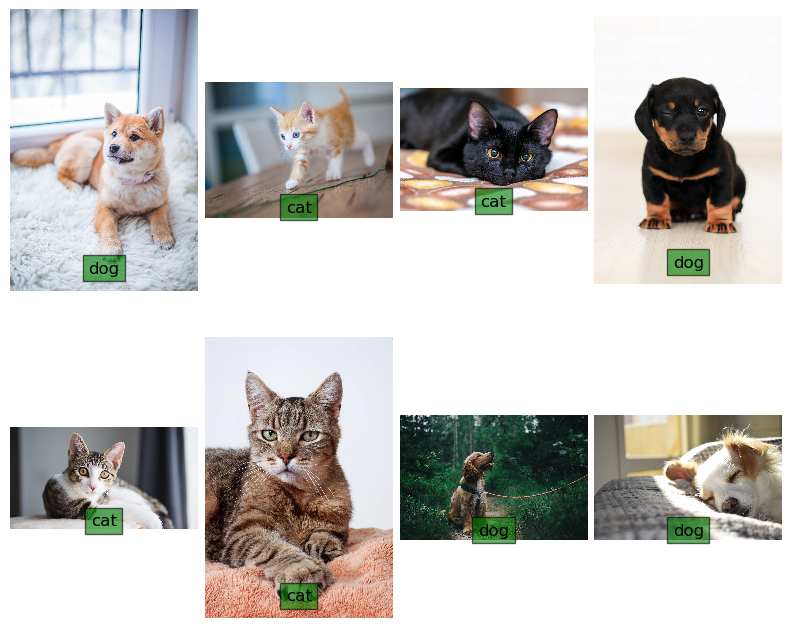

In [52]:
create_subplot(image_paths=local_images, concepts=labels_local, num_rows=2, figsize=(8, 8))

## Run Inference multiple images

Let's run inference on our local images.

In [53]:
predictions_local = get_images_predictions(MODEL_ID, MODEL_VERSION_ID, IMAGE_PATH = local_images)
predictions_local

[{'predicted concept': 'dog', 'value': 0.9954115748405457},
 {'predicted concept': 'cat', 'value': 0.9986248016357422},
 {'predicted concept': 'cat', 'value': 0.998708963394165},
 {'predicted concept': 'dog', 'value': 0.9982118606567383},
 {'predicted concept': 'cat', 'value': 0.9950992465019226},
 {'predicted concept': 'cat', 'value': 0.9995459914207458},
 {'predicted concept': 'dog', 'value': 0.9950265288352966},
 {'predicted concept': 'dog', 'value': 0.9979293346405029}]

In [54]:
mult_pred_local = pd.DataFrame(predictions_local)

## Basic evaluation report

Let's look at our results to see how well our model performed

Classification Report
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00         4
         dog       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



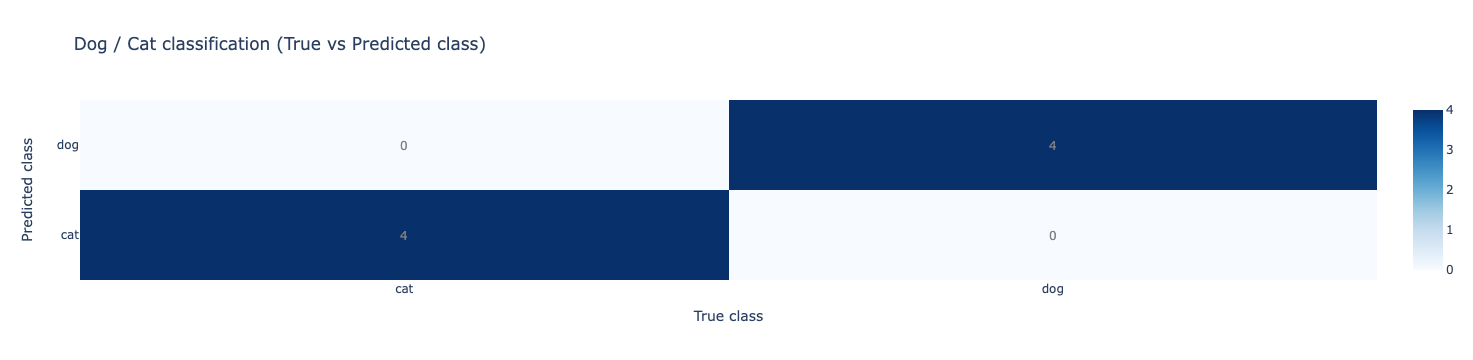

In [55]:

print_results(
    true_class=labels_local, 
    pred_class=mult_pred_local['predicted concept'], 
    class_labels=['cat', 'dog'], 
    title = "Dog / Cat classification (True vs Predicted class)"
)